### <p style="text-align: center;">Calibration of the Volatility Surface in FX Markets</p> 

**Volatility Surface** describes the implied volatility of options in terms of **Maturity** and **Strike Price** and is useful for pricing the options consistently.

This code explains the construction of the volatility surface in the FX market given that either of these are available at various **Maturity**:

a. $\sigma_{ATM}$, $\sigma_{\Delta-MS}$, $\sigma_{\Delta-RR}$, or

b. $\sigma_{ATM}$, $\sigma_{\Delta-Put}$, $\sigma_{\Delta-Call}$, 

where $\sigma_{ATM}$ denotes the volatility of the at-the-money option, $\sigma_{\Delta-MS}$ describes the strangle premium (Market Strangle) with a delta $\Delta$, $\sigma_{\Delta-RR}$ represents the Risk Reversal with a delta $\Delta$, while $\sigma_{\Delta-Put}$ and $\sigma_{\Delta-Call}$ are the put and call options with a delta $\Delta$.

First, consider the following construction of **Volatility Smile** at a given maturity **T**, $\sigma_T(K)$, must satisfy these three conditions:

\begin{equation*}
\begin{split}
\sigma_T(K_{ATM}) &= \sigma_{ATM},\\
V_{Put}\left(K_{\Delta-Put-MS}, T, \sigma_T\left(K_{\Delta-Put-MS}\right)\right) + V_{Call}\left(K_{\Delta-Call-MS}, T, \sigma_T(K_{\Delta-Call-MS})\right) &= V_{\Delta-MS},\\
\sigma_{\Delta-RR} &= \sigma_T\left({K_{\Delta-Call}}\right) - \sigma_T\left({K_{\Delta-Put}}\right).\\
\end{split}
\end{equation*}

1. $K_{ATM}$ in the first equation can be calculated directly according to its convention.
2. In the second equation, $K_{\Delta-Put-MS}$, $K_{\Delta-Call-MS}$, and $V_{\Delta-MS}$ satisfy:


\begin{equation*}
\begin{split}
\Delta_{Call}\left(K_{\Delta-Call-MS}, T, \sigma_{ATM}+\sigma_{\Delta-MS}\right) &=\Delta,\\
\Delta_{Put}\left(K_{\Delta-Put-MS}, T, \sigma_{ATM}+\sigma_{\Delta-MS}\right) &=-\Delta, \\
V_{Put}\left(K_{\Delta-Put-MS}, T, \sigma_{ATM}+\sigma_{\Delta-MS}\right) + V_{Call}\left(K_{\Delta-Call-MS}, T, \sigma_{ATM}+\sigma_{\Delta-MS}\right) &= V_{\Delta-MS},
\end{split}
\end{equation*}

where $V_{Put}\left(V_{Call}\right)$ and $\Delta_{Put}\left(\Delta_{Call}\right)$ represent the price and delta function of a put (call) option respectively.

3.  $K_{\Delta-Call}$ and $K_{\Delta-Put}$ are the strikes that can be found by solving:
\begin{equation*}
\begin{split}
\Delta_{Call}\left(K_{\Delta-Call}, T, \sigma_T\left(K_{\Delta-Call}\right)\right) &=\Delta,\\
\Delta_{Put}\left(K_{\Delta-Put}, T, \sigma_T\left(K_{\Delta-Put}\right)\right) &=-\Delta. \\
\end{split}
\end{equation*}

If $\sigma_{\Delta-Put}$ and $\sigma_{\Delta-Call}$ are known instead of $\sigma_{\Delta-MS}$ and $\sigma_{\Delta-RR}$, then the second and third equations are replaced by:

\begin{equation*}
\begin{split}
\frac{\sigma_{\Delta-Call}+\sigma_{\Delta-Put}}{2}-\sigma_{ATM} &= \frac{\sigma_T\left({K_{\Delta-Call}}\right)+\sigma_T\left({K_{\Delta-Put}}\right)}{2}-\sigma_T(K_{ATM}),\\
\sigma_{\Delta-Call}-\sigma_{\Delta-Put} &= \sigma_T\left({K_{\Delta-Call}}\right) - \sigma_T\left({K_{\Delta-Put}}\right).\\
\end{split}
\end{equation*}

In this code, $\sigma_T(K)$ has a parametric formula based on the SABR model with three parameters, $(\alpha, \nu, \rho)$ as follows
\begin{equation*}
\begin{split}
\sigma_T(K)&=\frac{\alpha z \left(1+\left[\frac{(1-\beta)^2\alpha^2}{24(FK)^{1-\beta}}+\frac{\rho\beta\nu\alpha}{4(FK)^{\frac{1-\beta}{2}}}+\frac{2-3\rho^2}{24}\nu^2\right]T\right)}{\chi\left(z\right)FK^{(1-\beta)/2}\left[1+\frac{(1-\beta)^2}{24}\ln^2\left(\frac{F}{K}\right)+\frac{(1-\beta)^4}{1920}\ln^4\left(\frac{F}{K}\right)\right]},\\
z&=\frac{\nu}{\alpha}(FK)^{\frac{1-\beta}{2}}\ln\left(\frac{F}{K}\right),\\
\chi(z)&=\ln\left(\frac{\sqrt{1-2\rho z+z^2}+z-\rho}{1-\rho}\right),\\
F&=Se^{(r_d-r_f)T},
\end{split}
\end{equation*}

where $F$ denotes the outright forward rates, $S$ the spot rate at initial time, $r_d$ and $r_f$ are the domestic and foreign interest rate.

Here the scale parameter $\beta\in[0, 1]$ is set to $\beta=1$, and therefore, the aim of this calibration is to find $(\alpha, \nu, \rho)$ such that $\sigma_T(K)$ satisfies the three conditions mentioned above.

In [2]:
import numpy as np
import datetime

import scipy
from scipy.stats import norm

import matplotlib
import matplotlib.pyplot as plt

In [3]:
class volatility_smile_fx:
    '''
    Calibration method to construct volatility smile in FX markets.
    SABR interpolation based on Risk Reversal, Market Strangle, and ATM volatility,
    or based on ATM volatility, Put and Call volatility with certain delta.

    Input:
    S : spot price
    r_d : domestic interest rate
    r_f : foreign interest rate
    T : time to maturity in years
    '''
    def __init__(self, S, r_d, r_f, T):
        # set parameters
        self.S = S
        self.r_d = r_d
        self.r_f = r_f
        self.T = T
        
        # set outright forward rates
        self.F = S*np.exp((r_d-r_f)*T)

    def price(self, K, sigma, option='call', conv='d/f'):
        '''
        Calculate the price of vanilla call or put options.

        Input:
        K = strike price
        sigma = volatility parameter in Black-Scholes model
        option = type of options (call or put)
        conv = type of price conventions 
        -domestic per foreign (d/f),
        -percentage of foreign (%f)

        Output:
        price of the option
        '''
        # calculate components used to calculated price
        d_plus = (np.log(self.S/K)+(self.r_d-self.r_f+sigma**2/2)*self.T) \
               / (sigma*np.sqrt(self.T))
        d_min = d_plus-sigma*np.sqrt(self.T)

        # price the option based on the given option type
        if option == 'call':
            phi = 1
        elif option == 'put':
            phi = -1
            
        price = phi*self.S*np.exp(-self.r_f*self.T)*norm.cdf(phi*d_plus) \
              - phi*K*np.exp(-self.r_d*self.T)*norm.cdf(phi*d_min)

        # convert and return the price
        if conv == '%f':
            return price/self.S
        elif conv == 'd/f':
            return price

    def delta(self, K, sigma, option='call', conv='S'):
        '''
        Calculate the delta of vanilla call or put options.

        Input:
        K = strike price
        sigma = volatility parameter in Black-Scholes model
        option = type of options (call or put)
        conv = type of delta conventions 
        -spot delta (S),
        -forward delta (F), 
        -percentage premium adjusted spot delta (%S),
        -percentage premium adjusted forward delta (%F),
        -simple delta (Simple)

        Output:
        delta of the option
        '''
        # calculate components used to calculated delta
        d_plus = (np.log(self.S/K)+(self.r_d-self.r_f+sigma**2/2)*self.T) \
               / (sigma*np.sqrt(self.T))
        d_min = d_plus-sigma*np.sqrt(self.T)

        # calculate the delta based on the given option and convention type
        if option == 'call':
            phi = 1
        elif option == 'put':
            phi = -1

        if conv == 'S':
            value = phi*np.exp(-self.r_f*self.T)*norm.cdf(phi*d_plus)
        elif conv == '%S':
            value = phi*np.exp(-self.r_d*self.T)*K/self.S*norm.cdf(phi*d_min)
        elif conv == 'F':
            value = phi*norm.cdf(phi*d_plus)
        elif conv == '%F':
            value = phi*K/self.F*norm.cdf(phi*d_min)
        elif conv == 'Simple':
            value = phi*norm.cdf(phi*np.log(self.F/K)/(sigma*np.sqrt(T)))
        return value

    def ATM_K(self, sigma, conv='S'):
        '''
        Define at-the-money strike price K.

        Input:
        sigma = volatility parameter in Black-Scholes model
        conv = type of the at-the-money convention

        -ATM spot, K=S (S),
        -ATM foward, K=F (F),
        -DNS forward, K such that delta F call = -delta F put (DNS-F),
        -DNS %forward, K such that delta %F call = -delta %F put (DNS-%F)
        '''

        # calculate the strike price according to the convention
        if conv == 'S':
            return self.S
        elif conv == 'F':
            return self.F
        elif conv == 'DNS-F':
            return self.F*np.exp(sigma**2/2*self.T)
        elif conv == 'DNS-%F':
            return self.F*np.exp(-sigma**2/2*self.T)


    def strangle_K(self, sigma, delta=0.25, conv='S'):
        '''
        Define the Call and Put strike based on market strangle.

        Input:
        sigma = volatility parameter in Black-Scholes model, sigma_ATM+sigma_d_MS
        delta = delta corresponds to sigma_d_MS
        conv = type of delta conventions 
        -spot delta (S),
        -forward delta (F), 
        -percentage premium adjusted spot delta (%S),
        -percentage premium adjusted forward delta (%F),
        -simple delta (Simple)

        Output:
        Call and Put strike 
        '''

        # the strike prices must satisfy these functions=0
        delta_K_call = lambda K: self.delta(K, sigma, option='call', conv=conv)-delta
        delta_K_put = lambda K: self.delta(K, sigma, option='put', conv=conv)+delta

        return (scipy.optimize.root(delta_K_call, x0=self.S).x[0],
                scipy.optimize.root(delta_K_put, x0=self.S).x[0])

    
    def SABR(self, params, K, beta=1):
        '''
        SABR volatility model, parameteric formulation to estimate the implied volatility.

        Input:
        params = a list of parameters consist of
        -alpha, initial volatility
        -nu, volatility of volatility
        -rho, correlation between spot and volatility
        K = strike price
        beta = shape parameter

        Output:
        estimated volatility
        '''
        # set the parameters
        alpha = params[0]
        nu = params[1]
        rho = params[2]

        # calculate components used to calculate the volatility
        z = (nu/alpha)*(self.F*K)**((1-beta)/2)*np.log(self.F/K)
        chi = lambda z: np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))

        c11 = (self.F*K)**((1-beta)/2)
        c12 = ((1-beta)**2/24)*np.log(self.F/K)**2
        c13 = ((1-beta)**4/1920)*np.log(self.F/K)**4
        c1 = c11*(1+c12+c13)

        c21 = ((1-beta)**2/24)*alpha**2/((self.F*K)**(1-beta))
        c22 = (1/4)*(rho*beta*nu*alpha)/(self.F*K)**((1-beta)/2)
        c23 = ((2-3*rho**2)/24)*nu**2
        c2 = 1+(c21+c22+c23)*self.T

        return alpha*z*c2/(c1*chi(z))


    def rr_K(self, params, delta=0.25, conv='S'):        
        '''
        Define the Call and Put strike based on risk reversal.

        Input:
        params = a list of parameters for SABR model
        delta = delta corresponds to sigma_d_RR
        conv = type of delta conventions 
        -spot delta (S),
        -forward delta (F), 
        -percentage premium adjusted spot delta (%S),
        -percentage premium adjusted forward delta (%F),
        -simple delta (Simple)

        Output:
        Call and Put strike
        '''

        # given the SABR model, calculate the corresponding Call and Put strike price
        delta_K_call = lambda K: self.delta(K, self.SABR(params, K), option='call', conv=conv)-delta
        delta_K_put = lambda K: self.delta(K, self.SABR(params, K), option='put', conv=conv)+delta

        return (scipy.optimize.root(delta_K_call, x0=self.S).x[0],
                scipy.optimize.root(delta_K_put, x0=self.S).x[0])

    def calibration(self, sigma_ATM, sigma_d_MS, sigma_d_RR, conv=['DNS-F', 'S', 'S'], delta=0.25):
        '''
        Calibration of the model, find the optimal SABR parameters that consistent with the market.

        Input:
        sigma_ATM = sigma of the ATM strike price
        sigma_d_MS = sigma of the Market Strangle
        sigma_d_RR = sigma of the Risk Reversal
        conv = a list of conventions used to define
        -ATM,
        -delta of the Market Strangle,
        -delta of the Risk Reversal
        delta = delta corresponds to sigma_d_MS and sigma_d_RR
        '''
        # Step-1: Find K_ATM
        K_ATM = self.ATM_K(sigma=sigma_ATM, conv=conv[0])

        # Step 2: Find K_d_C_MS and K_d_P_MS
        K_d_C_MS, K_d_P_MS = self.strangle_K(sigma=sigma_ATM+sigma_d_MS, delta=delta, conv=conv[1])

        # Step 3: Set one of the objective about MS price
        V_target = self.price(K_d_C_MS, sigma=sigma_ATM+sigma_d_MS, option='call') \
                 + self.price(K_d_P_MS, sigma=sigma_ATM+sigma_d_MS, option='put')

        # Step 4: Define objective function
        def obj_f(SABR_parameter):
            # Step 5: Find K_d_C, K_d_P
            K_d_C, K_d_P = self.rr_K(params=SABR_parameter, delta=delta, conv=conv[2])

            # first objective: 
            obj_1 = self.SABR(params=SABR_parameter, K=K_ATM)-sigma_ATM
            # second objective:
            obj_2 = (self.SABR(params=SABR_parameter, K=K_d_C)
                    -self.SABR(params=SABR_parameter, K=K_d_P)) \
                  -sigma_d_RR
            # third objective:
            obj_3 = self.price(K_d_C_MS, sigma=self.SABR(params=SABR_parameter, K=K_d_C_MS),
                               option='call') \
                  + self.price(K_d_P_MS, sigma=self.SABR(params=SABR_parameter, K=K_d_P_MS),
                               option='put') \
                  - V_target

            return np.array([obj_1, obj_2, obj_3])

        # Step 6: Find calibrated SABR_parameter using least-squares method
        calibrated_params = scipy.optimize.least_squares(obj_f, x0=[sigma_ATM, sigma_ATM, 0],
                                                         bounds=([0, 0, -1], [np.inf, np.inf, 1])).x

        # apply the calibrated parameters
        self.params = calibrated_params

    def rr_K_II(self, sigma_d_C, sigma_d_P, delta=0.25, conv='S'):
        '''
        Define the Call and Put strike based on risk-reversal,
        if volatility of the Call and Put with certain delta is known.
        
        Input:
        sigma_d_C = sigma of the Call with certain delta
        sigma_d_P = sigma of the Put with certain delta
        delta = delta of the Put and Call
        conv = type of delta conventions 
        -spot delta (S),
        -forward delta (F), 
        -percentage premium adjusted spot delta (%S),
        -percentage premium adjusted forward delta (%F),
        -simple delta (Simple)

        Output:
        strike price of the Call and Put options
        '''
        delta_K_call = lambda K: self.delta(K, sigma=sigma_d_C, option='call', conv=conv)-delta
        delta_K_put = lambda K: self.delta(K, sigma=sigma_d_P, option='put', conv=conv)+delta

        return (scipy.optimize.root(delta_K_call, x0=self.S).x[0],
                scipy.optimize.root(delta_K_put, x0=self.S).x[0])

    def calibration_II(self, sigma_d_P, sigma_ATM, sigma_d_C, conv=['DNS-F', 'S'], delta=0.25):
        '''
        Calibration of the model, find the optimal SABR parameters that consistent with the market.
        This function utilises sigma_d_P and sigma_d_C instead of sigma_d_RR and sigma_d_MS.

        Input:
        sigma_ATM = sigma of the ATM strike price
        sigma_d_C = sigma of the Call with certain delta
        sigma_d_P = sigma of the Put with certain delta
        conv = a list of conventions used to define
        -ATM,
        -delta of the Put and Call options
        delta = delta corresponds to sigma_d_C and sigma_d_P
        '''
        # Step 1: Find K_ATM, K_d_C, K_d_P
        K_ATM = self.ATM_K(sigma=sigma_ATM, conv=conv[0])
        K_d_C, K_d_P = self.rr_K_II(sigma_d_C=sigma_d_C,
                                    sigma_d_P=sigma_d_P,
                                    delta=delta,
                                    conv=conv[1])
        
        # Step 2: Set Sigma_d_RR and Sigma_d_SS
        sigma_d_RR = sigma_d_C-sigma_d_P
        sigma_d_SS = (sigma_d_C+sigma_d_P)/2-sigma_ATM

        
        
        # Step 3: Define objective function
        def obj_f(SABR_parameter):
            # first objective: 
            obj_1 = self.SABR(params=SABR_parameter, K=K_ATM)-sigma_ATM
            # second objective:
            obj_2 = (self.SABR(params=SABR_parameter, K=K_d_C)
                    -self.SABR(params=SABR_parameter, K=K_d_P)) \
                  -sigma_d_RR
            # third objective:
            obj_3 = (self.SABR(params=SABR_parameter, K=K_d_C)
                    +self.SABR(params=SABR_parameter, K=K_d_P))/2 \
                  - self.SABR(params=SABR_parameter, K=K_ATM)-sigma_d_SS

            return np.array([obj_1, obj_2, obj_3])

        # Step 4: Find calibrated SABR_parameter
        calibrated_params = scipy.optimize.least_squares(obj_f,
                                                         x0=[sigma_ATM, sigma_ATM, 0],
                                                         bounds=([0, 0, -1],
                                                                 [np.inf, np.inf, 1])).x
        # apply the calibrated parameters
        self.params = calibrated_params

### Volatility Smile - Parameter Initialisation

In [5]:
# parameter initialisation
S = 1.4
r_d = 0.03
r_f = 0.04
T = [0.5, 1]

# market data initialisation
sigma_ATM = [0.2, 0.18]
sigma_d_MS = [0.01, 0.01125]
sigma_d_RR = [-0.004, -0.005]

### Volatility Smile - Calibration Process

In [7]:
model_0 = volatility_smile_fx(S=S, r_d=r_d, r_f=r_f, T=T[0])
model_1 = volatility_smile_fx(S=S, r_d=r_d, r_f=r_f, T=T[1])

# calibration process
model_0.calibration(sigma_ATM=sigma_ATM[0],
                    sigma_d_MS=sigma_d_MS[0],
                    sigma_d_RR=sigma_d_RR[0],
                    conv=['DNS-F', 'F', 'F'],
                    delta=0.25)

model_1.calibration(sigma_ATM=sigma_ATM[1],
                    sigma_d_MS=sigma_d_MS[1],
                    sigma_d_RR=sigma_d_RR[1],
                    conv=['DNS-F', 'F', 'F'],
                    delta=0.25)

### Volatility Smile - Visualisation

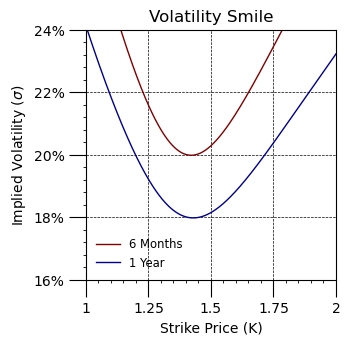

In [9]:
x = np.linspace(1, 2, 1001)
y_0 = model_0.SABR(params=model_0.params, K=x)*100
y_1 = model_1.SABR(params=model_1.params, K=x)*100

xmin, xmax = min(x), max(x)
ymin, ymax = 16, 24

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.25, 0.25, 0.5, 0.5])
ax.plot(x, y_0, color='maroon', linewidth=1, label='6 Months')
ax.plot(x, y_1, color='darkblue', linewidth=1, label='1 Year')

ax.set(xlim=[xmin, xmax],
       ylim=[ymin, ymax],
       ylabel=r'Implied Volatility ($\sigma$)',
       xlabel='Strike Price (K)',
       title='Volatility Smile')

    
tickerx_major = matplotlib.ticker.MultipleLocator(0.25, offset=xmin)
tickerx_minor = matplotlib.ticker.MultipleLocator(0.05, offset=xmin)
tickery_major = matplotlib.ticker.MultipleLocator(2, offset=ymin)
tickery_minor = matplotlib.ticker.MultipleLocator(0.4, offset=ymin)

ax.xaxis.set(major_locator=tickerx_major,
             minor_locator=tickerx_minor,
             major_formatter=matplotlib.ticker.StrMethodFormatter('{x:g}'))

ax.yaxis.set(major_locator=tickery_major,
             minor_locator=tickery_minor,
             major_formatter=matplotlib.ticker.StrMethodFormatter('{x:g}%'))

ax.tick_params(length=12)
ax.grid(linestyle='--', color='k', linewidth=0.5)
plt.legend(loc='lower left',
           fontsize='small', framealpha=0, facecolor=(0, 0, 0, 0))
fig.savefig('Volatile Smile.png', dpi=300, transparent=True)
plt.show()

## Interpolation

Interpolation is an integral part of constructing the volatility surface from the volatility smile $\sigma_T(K)$.

Constructing the volatility smile at time $T=t\in[T_1, T_2]$ can be done with the following steps:
1. Obtain $K_{ATM}$, $K_{\Delta-Call}$, and $K_{\Delta-Put}$ at maturity $T_1$ and $T_2$,
2. Use these strikes to obtain $\sigma_t(K_{ATM})$, $\sigma_t(K_{\Delta-Call})$, and $\sigma_t(K_{\Delta-Call})$ by using the flat forward volatility interpolation:
   
\begin{equation*}
\sigma^2_t(K)t = \frac{T_2-t}{T_2-T_1}\sigma^2_{T_1}(K)T_1 + \frac{t-T_1}{T_2-T_1}\sigma^2_{T_2}(K)T_2,
\end{equation*}

4. Construct the volatility smile at time $T=t$ with the same method mentioned above by utilising $\sigma_t(K_{ATM})$, $\sigma_t(K_{\Delta-Call})$, and $\sigma_t(K_{\Delta-Call})$.

In [11]:
def interpolate(t, sigma_1, t_1, sigma_2, t_2):
    '''
    Linear interpolation in integrated variance.

    Input:
    t: time between t_1 and t_2
    sigma_1: volatility at time t_1
    t_1: reference time in year, t_1 < t_2 
    sigma_2: volatility at time t_2
    t_2: reference time in year, t_1 < t_2

    Output:
    estimated volatility at time t
    '''
    c1 = (t_2/t)*(t-t_1)/(t_2-t_1)*sigma_2**2
    c2 = (t_1/t)*(t_2-t)/(t_2-t_1)*sigma_1**2
    return np.sqrt(c1+c2)

### Volatility Smile - Interpolation Process

In [13]:
# obtain K_ATM, K_d_C, and K_d_P from both models
K_ATM_0, K_ATM_1 = (model_0.ATM_K(sigma_ATM[0], conv='DNS-F'),
                    model_1.ATM_K(sigma_ATM[1], conv='DNS-F'))

K_d_C_0, K_d_P_0 = model_0.rr_K(params=model_0.params,
                                conv='F', delta=0.25)
K_d_C_1, K_d_P_1 = model_1.rr_K(params=model_1.params,
                                conv='F', delta=0.25)

# obtain the estimated volatility
vol_0 = model_0.SABR(params=model_0.params,
                     K=np.array([K_d_P_0, K_ATM_0, K_d_C_0]))
vol_1 = model_1.SABR(params=model_1.params,
                     K=np.array([K_d_P_1, K_ATM_1, K_d_C_1]))

# interpolate at time T=0.75
T_i = 0.75
vol_i = interpolate(T_i, vol_0, T[0], vol_1, T[1])

# create model and do the calibration process at time T=0.75
model_i = volatility_smile_fx(S=S, r_d=r_d, r_f=r_f, T=T_i)
model_i.calibration_II(sigma_d_P=vol_i[0],
                       sigma_ATM=vol_i[1],
                       sigma_d_C=vol_i[2],
                       conv=['DNS-F', 'F'],
                       delta=0.25)

### Volatility Smile - Visualisation (Interpolation)

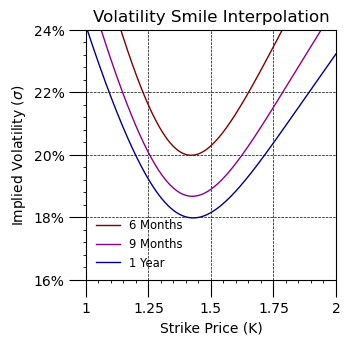

In [15]:
x = np.linspace(1, 2, 1001)
y_0 = model_0.SABR(params=model_0.params, K=x)*100
y_1 = model_1.SABR(params=model_1.params, K=x)*100
y_i = model_i.SABR(params=model_i.params, K=x)*100

xmin, xmax = min(x), max(x)
ymin, ymax = 16, 24

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.25, 0.25, 0.5, 0.5])
ax.plot(x, y_0, color='maroon', linewidth=1, label='6 Months')
ax.plot(x, y_i, color='darkmagenta', linewidth=1, label='9 Months')
ax.plot(x, y_1, color='darkblue', linewidth=1, label='1 Year')


ax.set(xlim=[xmin, xmax],
       ylim=[ymin, ymax],
       ylabel=r'Implied Volatility ($\sigma$)',
       xlabel='Strike Price (K)',
       title='Volatility Smile Interpolation')

    
tickerx_major = matplotlib.ticker.MultipleLocator(0.25, offset=xmin)
tickerx_minor = matplotlib.ticker.MultipleLocator(0.05, offset=xmin)
tickery_major = matplotlib.ticker.MultipleLocator(2, offset=ymin)
tickery_minor = matplotlib.ticker.MultipleLocator(0.4, offset=ymin)

ax.xaxis.set(major_locator=tickerx_major,
             minor_locator=tickerx_minor,
             major_formatter=matplotlib.ticker.StrMethodFormatter('{x:g}'))

ax.yaxis.set(major_locator=tickery_major,
             minor_locator=tickery_minor,
             major_formatter=matplotlib.ticker.StrMethodFormatter('{x:g}%'))

ax.tick_params(length=12)
ax.grid(linestyle='--', color='k', linewidth=0.5)
plt.legend(loc='lower left',
           fontsize='small', framealpha=0, facecolor=(0, 0, 0, 0))
fig.savefig('Volatile Smile Interpolation.png', dpi=300, transparent=True)
plt.show()

### Volatility Surface - Parameter Initialisation

In [17]:
# parameter initialisation
S = 1.4
r_d = 0.03
r_f = 0.04

# instead of using T in years,
# define T in date format to reflect real-life market
# note: this method can be adjusted to incorporate weekends
n_days = 366
date = datetime.datetime(2024, 1, 1)
T_date = [datetime.datetime(2024, 2, 1),
          datetime.datetime(2024, 3, 1),
          datetime.datetime(2024, 4, 1),
          datetime.datetime(2024, 7, 1),
          datetime.datetime(2025, 1, 1)]

# define T in years
T = [(t-date).days/n_days for t in T_date]

# define number of days between the first to last available maturity
range_T = (T_date[-1]-T_date[0]).days

# define number of days to the first maturity date
first_maturity = T[0]*n_days

# market data at maturity dates
sigma_ATM = [0.225, 0.225, 0.205, 0.2, 0.18]
sigma_d_MS = [0.0065, 0.009, 0.01, 0.01, 0.01125]
sigma_d_RR = [-0.002, -0.0025, -0.003, -0.004, -0.005]

### Volatility Surface - Volatility Smile Construction

In [19]:
# create initial volatility matrix between the first and last maturity dates
# row-days, column-volatility type (sigma_d_P, sigma_ATM, sigma_d_C)
vol = np.zeros(shape=(range_T+1, 3))

# placeholder to denote which rows have available maturity
avail_row = []

model = {}
for t, s_ATM, s_MS, s_RR in zip(T, sigma_ATM, sigma_d_MS, sigma_d_RR):
    # model index as number of days since the first maturity date
    # i=0 denotes the first maturity date
    i = int(np.round(t*n_days-first_maturity))

    # model calibration
    model[i] = volatility_smile_fx(S=S, r_d=r_d, r_f=r_f, T=t)
    model[i].calibration(sigma_ATM=s_ATM,
                         sigma_d_MS=s_MS,
                         sigma_d_RR=s_RR,
                         conv=['DNS-F', 'F', 'F'],
                         delta=0.25)

    # save volatilities for interpolation
    K_d_C, K_d_P = model[i].rr_K(params=model[i].params, conv='F')
    K_ATM = model[i].ATM_K(sigma=s_ATM, conv='DNS-F')
    vol[i, :] = model[i].SABR(params=model[i].params, 
                              K=np.array([K_d_P, K_ATM, K_d_C]))
    
    avail_row.append(i)

avail_row = np.array(avail_row)

### Volatility Surface - Interpolation Process

In [21]:
for i in range(range_T+1):
    # interpolate if the row in volatility matrix is empty
    if i not in avail_row:
        # obtain t_1 and t_2 for interpolation
        index = np.where(avail_row<i)[0].max()
        t_1 = avail_row[index]
        t_2 = avail_row[index+1]

        # interpolation process
        # add first_maturity, but it is not necessary to divide with n_days
        vol[i, :] = interpolate(i+first_maturity, vol[t_1, :],
                                t_1+first_maturity, vol[t_2, :],
                                t_2+first_maturity)

        # calibration process
        model[i] = volatility_smile_fx(S=S, r_d=r_d, r_f=r_f,
                                       T=(i+first_maturity)/n_days)
        model[i].calibration_II(sigma_d_P = vol[i, 0],
                                sigma_ATM = vol[i, 1],
                                sigma_d_C = vol[i, 2],
                                conv=['DNS-F', 'F'],
                                delta=0.25)
        

### Volatility Surface - Visualisation

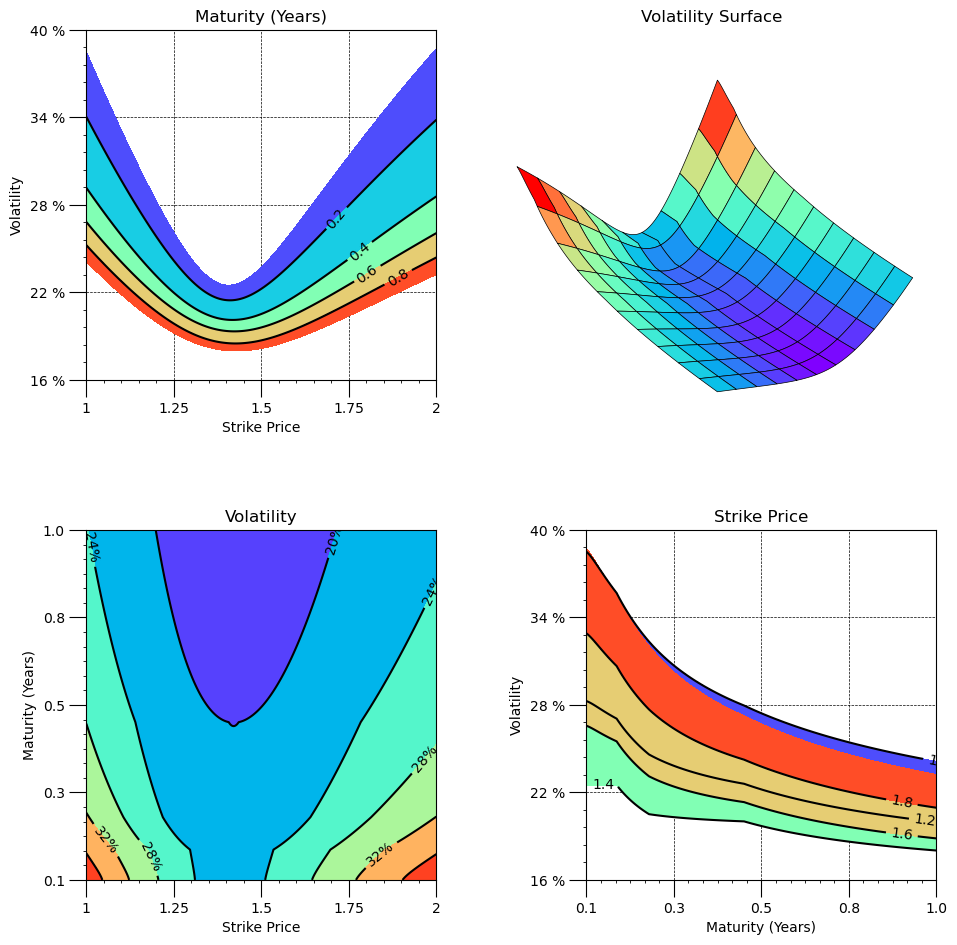

In [37]:
x = np.linspace(1, 2, 1001)
y = np.linspace(0, range_T, range_T+1)
Z = np.zeros(shape=(len(x), len(y)))

for i in y:
    i = int(np.round(i))
    Z[:, i] = model[i].SABR(params=model[i].params, K=x)*100

Z = Z.T
y = (y+first_maturity)/n_days
X, Y = np.meshgrid(x, y)

xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)
zmin, zmax = 16, 40

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0.5, 0.5, 0.45, 0.45], projection='3d')
ax_xy = fig.add_axes([0.1, 0.1, 0.35, 0.35])
ax_yz = fig.add_axes([0.6, 0.1, 0.35, 0.35])
ax_xz = fig.add_axes([0.1, 0.6, 0.35, 0.35])

ax.plot_surface(X, Y, Z, cmap='rainbow', facecolor=(1,1,1,0), edgecolor='k', lw=0.5,
                rcount=10, ccount=10)


ax_xy.contourf(X, Y, Z, cmap='rainbow', levels=5, zorder=2)
c_xy = ax_xy.contour(X, Y, Z, colors='k', levels=5, zorder=2)
ax_xy.clabel(c_xy, c_xy.levels,
             fmt=matplotlib.ticker.StrMethodFormatter('{x:g}%'),
             inline=True, zorder=2)

ax_xz.contourf(X, Z, Y, cmap='rainbow', levels=5, zorder=2)
c_xz = ax_xz.contour(X, Z, Y, colors='k', levels=5, zorder=2)
ax_xz.clabel(c_xz, c_xz.levels,
             fmt=matplotlib.ticker.StrMethodFormatter('{x:g}'),
             inline=True, zorder=2)

ax_yz.contourf(Y, Z, X, cmap='rainbow', levels=5, zorder=2)
c_yz = ax_yz.contour(Y, Z, X, colors='k', levels=5, zorder=2)
ax_yz.clabel(c_yz, c_yz.levels,
             fmt=matplotlib.ticker.StrMethodFormatter('{x:g}'),
             inline=True, zorder=2)

ax_xy.set(xlim=[xmin, xmax],
          ylim=[ymin, ymax],
          ylabel='Maturity (Years)',
          xlabel='Strike Price',
          title='Volatility')

ax_xz.set(xlim=[xmin, xmax],
          ylim=[zmin, zmax],
          ylabel='Volatility',
          xlabel='Strike Price',
          title='Maturity (Years)')

ax_yz.set(xlim=[ymin, ymax],
          ylim=[zmin, zmax],
          ylabel='Volatility',
          xlabel='Maturity (Years)',
          title='Strike Price')

    
tickerx_major = matplotlib.ticker.MultipleLocator(0.25, offset=xmin)
tickerx_minor = matplotlib.ticker.MultipleLocator(0.05, offset=xmin)
tickery_major = matplotlib.ticker.LinearLocator(5)
tickery_minor = matplotlib.ticker.LinearLocator(25)
tickerz_major = matplotlib.ticker.MultipleLocator(6, offset=zmin)
tickerz_minor = matplotlib.ticker.MultipleLocator(1.2, offset=zmin)

ax_xy.xaxis.set(major_locator=tickerx_major,
                minor_locator=tickerx_minor,
                major_formatter=matplotlib.ticker.StrMethodFormatter('{x:g}'))
ax_xy.yaxis.set(major_locator=tickery_major,
                minor_locator=tickery_minor,
                major_formatter=matplotlib.ticker.StrMethodFormatter('{x:.1f}'))

ax_xz.xaxis.set(major_locator=tickerx_major,
                minor_locator=tickerx_minor,
                major_formatter=matplotlib.ticker.StrMethodFormatter('{x:g}'))
ax_xz.yaxis.set(major_locator=tickerz_major,
                minor_locator=tickerz_minor,
                major_formatter=matplotlib.ticker.StrMethodFormatter('{x:g} %'))

ax_yz.xaxis.set(major_locator=tickery_major,
                minor_locator=tickery_minor,
                major_formatter=matplotlib.ticker.StrMethodFormatter('{x:.1f}'))
ax_yz.yaxis.set(major_locator=tickerz_major,
                minor_locator=tickerz_minor,
                major_formatter=matplotlib.ticker.StrMethodFormatter('{x:g} %'))

for axis in [ax_xy, ax_xz, ax_yz]:
    axis.tick_params(length=12, zorder=-3)
    axis.grid(linestyle='--', color='k', linewidth=0.5)

ax.set(xlim=[xmin, xmax],
       ylim=[ymin, ymax],
       zlim=[zmin, zmax],
       title='Volatility Surface')

ax.view_init(elev=30, azim=45, roll=0)
ax.xaxis.set_pane_color((1, 1, 1, 0))
ax.yaxis.set_pane_color((1, 1, 1, 0))
ax.zaxis.set_pane_color((1, 1, 1, 0))
ax.axis('off')
fig.savefig('Volatility Surface.png', dpi=300, transparent=False)
plt.show()